# __Assignment 2__

__Team Members__
<br>Veera Anand
<br>Aarav Dewangan
<br>Samuel Martinez Koss
<br>John Melel

In [1]:
import cudf
import cuml
import cupy

print("cuDF version:", cudf.__version__)
print("cuML version:", cuml.__version__)
print("CuPy version:", cupy.__version__)

cuDF version: 25.02.02
cuML version: 25.02.01
CuPy version: 13.4.1


In [2]:
#All libraries are imported here
import cupy as cp
import cudf
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_california_housing
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.linear_model import ElasticNet
from cuml.model_selection import GridSearchCV
from cuml.metrics import mean_squared_error
from sklearn.model_selection import KFold
import warnings

## __Elastic Net Question 1__
#### __1.1: Load the diabetes dataset. Make sure to load the features (X) and target (y) separately.__

In [3]:
diabetes_data = load_diabetes()

# Convert data to cuDF DataFrame and Series
X = cudf.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = cudf.Series(diabetes_data.target, name='target')

print(X.head())
print(y.head())

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  
0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


#### __1.2 Compute a summary statistics (count, mean, standard deviation, min, 25%, 50%, 75% percentiles, max) for each variable including the target__

In [4]:
df = X.copy()
df['target'] = y

# Use cuDF's describe method for summary statistics
sum_stats = df.describe()
print(sum_stats)

              age         sex         bmi          bp          s1          s2  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean     0.000000    0.000000   -0.000000   -0.000000   -0.000000    0.000000   
std      0.047619    0.047619    0.047619    0.047619    0.047619    0.047619   
min     -0.107226   -0.044642   -0.090275   -0.112399   -0.126781   -0.115613   
25%     -0.037299   -0.044642   -0.034229   -0.036656   -0.034248   -0.030358   
50%      0.005383   -0.044642   -0.007284   -0.005670   -0.004321   -0.003819   
75%      0.038076    0.050680    0.031248    0.035644    0.028358    0.029844   
max      0.110727    0.050680    0.170555    0.132044    0.153914    0.198788   

               s3          s4          s5          s6      target  
count  442.000000  442.000000  442.000000  442.000000  442.000000  
mean    -0.000000   -0.000000    0.000000    0.000000  152.133484  
std      0.047619    0.047619    0.047619    0.047619   77.093005 

#### __1.3 Plot a bar chart showing the correlation between the target and each feature.__

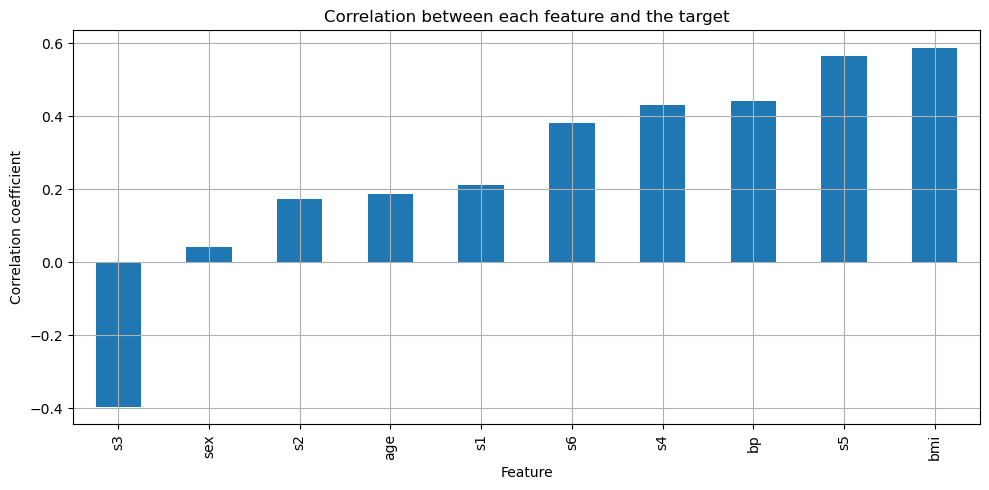

In [5]:
# Compute correlations using cuDF
correlations = df.corr()['target'].drop('target')

# Convert the cuDF Series to a pandas Series for plotting
correlations_pandas = correlations.to_pandas()  # Convert to pandas Series

# Plot the correlations
plt.figure(figsize=(10, 5))
correlations_pandas.sort_values().plot(kind='bar')  # Use pandas Series for plotting
plt.title('Correlation between each feature and the target')
plt.ylabel('Correlation coefficient')
plt.xlabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

#### __1.4 Normalize and split the data into training, validation, and testing datasets.__

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

feature_names = X.columns

# Scale the features using cuML's StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.columns = feature_names
X_test.columns = feature_names

In [7]:
original_filters = warnings.filters[:]
# Suppress all warnings
warnings.filterwarnings("ignore")

#### __1.5 Initiate a elasticnet in sklearn. Select a range of values of alpha and l1_ratio (hyperparameter space), set up the GridSearchCV with cv=3 and scoring='negative_mean_squared_error' and execute the model fit.__

#### __1.6 Report the cross-validation results__

In [8]:
# Parameters
alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]

kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = []

# Grid search loop
for alpha in alphas:
    for l1_ratio in l1_ratios:
        scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr = X_train.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_val = X_train.iloc[val_idx]
            y_val = y_train.iloc[val_idx]

            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            neg_mse = -1 * mean_squared_error(y_val.to_cupy(), y_pred.to_cupy())
            scores.append(neg_mse)

        avg_score = cp.mean(cp.array(scores))
        results.append((alpha, l1_ratio, avg_score))

# Sort and display
results_df = cudf.DataFrame(results, columns=['alpha', 'l1_ratio', 'mean_nmse'])
results_df = results_df.sort_values(by='mean_nmse', ascending=False)
print(results_df)

    alpha  l1_ratio    mean_nmse
2    0.01       0.9 -3144.648188
1    0.01       0.5 -3145.259201
0    0.01       0.1 -3146.588056
5    0.10       0.9 -3148.316837
4    0.10       0.5 -3149.565166
3    0.10       0.1 -3151.301327
8    1.00       0.9 -3173.623697
7    1.00       0.5 -3287.032793
6    1.00       0.1 -3423.869410
11  10.00       0.9 -3816.288717
10  10.00       0.5 -4555.001408
9   10.00       0.1 -4840.435679


#### __1.7 Which model was selected?__

#### the best combo is alpha = 0.01, L1 ratio of 0.9 which has the least negative MSE of -3144.648188

In [9]:
warnings.filters = original_filters

#### __1.8 Evaluate the model on the test dataset. Report the squared root of the mean squared error.__

In [10]:
# 1. Get best parameters from results
best_params = results_df.iloc[0]
best_alpha = float(best_params['alpha'])
best_l1 = float(best_params['l1_ratio'])

# 2. Train model on full training data
final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10000)
final_model.fit(X_train, y_train)

# 3. Predict and evaluate on test set
y_pred = final_model.predict(X_test)

# Ensure y_test and y_pred are both cupy arrays for metric
rmse_val = mean_squared_error(y_test.to_cupy(), y_pred.to_cupy(), squared=False)

print(f"Test RMSE: {rmse_val:.2f}")


Test RMSE: 50.83


#### __1.9 Plot a bar chart with the final parameter estimates.__

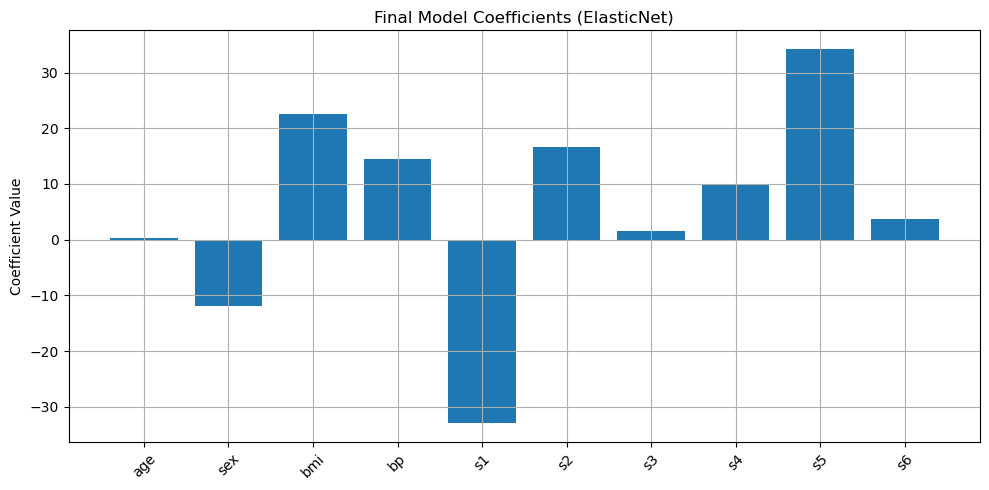

In [11]:
ft_names = X_train.columns.tolist()

# Get coefficients from trained model
coef = final_model.coef_

# Convert CuPy array to NumPy for plotting
coef_np = cp.asnumpy(coef)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(ft_names, coef_np)
plt.xticks(rotation=45)
plt.title("Final Model Coefficients (ElasticNet)")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## __Elastic Net Question 2__
#### __2.0 Load the data and review information about the data.__

In [12]:
url = "https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data"
df = cudf.read_csv(url, sep="\t", index_col=0)

print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nShape:", df.shape)

     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa  \
1 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0 -0.430783   
2 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0 -0.162519   
3 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20 -0.162519   
4 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0 -0.162519   
5  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0  0.371564   

  train  
1     T  
2     T  
3     T  
4     T  
5     T  

Columns: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45', 'lpsa', 'train']

Shape: (97, 10)


#### __2.1 Load the dataset. Make sure to load the features (X) and target (y) separately.__

In [13]:
df_train = df[df['train'] == 'T'].drop(columns=['train'])
df_test = df[df['train'] == 'F'].drop(columns=['train'])

X_train = df_train.drop(columns=['lpsa'])
y_train = df_train['lpsa']

X_test = df_test.drop(columns=['lpsa'])
y_test = df_test['lpsa']

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Train X: (67, 8)
Train y: (67,)
Test X: (30, 8)
Test y: (30,)


#### __2.2 Compute a summary statistics (count, mean, standard deviation, min, 25%, 50%, 75% percentiles, max) for each variable including the target.__

In [14]:
train_df = X_train.copy()
train_df['lpsa'] = y_train

# Use cuDF's describe method for summary statistics
sum_stats_2 = train_df.describe()
print(sum_stats_2)

          lcavol    lweight        age       lbph        svi        lcp  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    1.313492   3.626108  64.746269   0.071440   0.223881  -0.214203   
std     1.242590   0.476601   7.502208   1.463655   0.419989   1.400735   
min    -1.347074   2.374906  41.000000  -1.386294   0.000000  -1.386294   
25%     0.488279   3.330359  61.000000  -1.386294   0.000000  -1.386294   
50%     1.467874   3.598681  65.000000  -0.051293   0.000000  -0.798508   
75%     2.349065   3.883610  69.000000   1.547506   0.000000   0.994793   
max     3.821004   4.780383  79.000000   2.326302   1.000000   2.656757   

         gleason       pgg45       lpsa  
count  67.000000   67.000000  67.000000  
mean    6.731343   26.268657   2.452345  
std     0.708864   29.301764   1.207812  
min     6.000000    0.000000  -0.430783  
25%     6.000000    0.000000   1.667306  
50%     7.000000   15.000000   2.568788  
75%     7.000000   50.000000  

#### __2.3 Plot a bar chart showing the correlation between the target and each feature.__

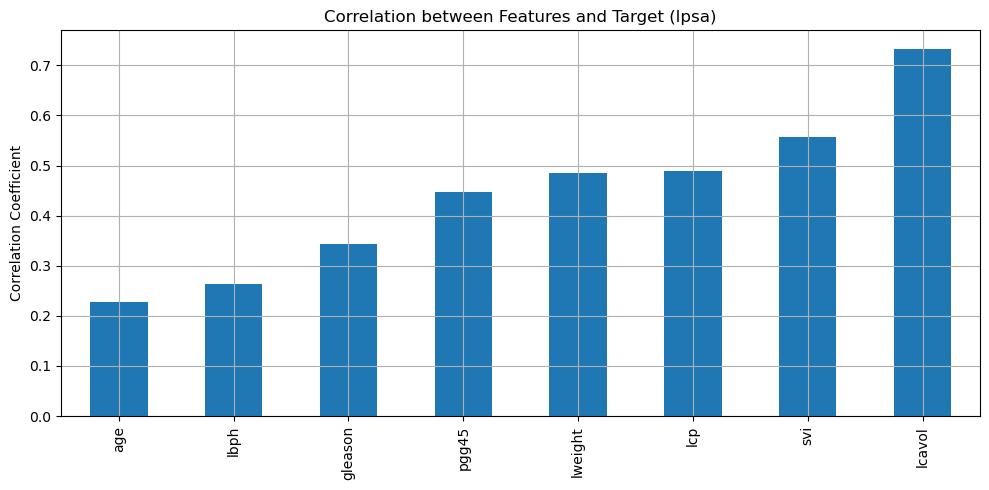

In [15]:
corr_2 = train_df.corr()['lpsa'].drop('lpsa')

plt.figure(figsize=(10, 5))
corr_2.sort_values().to_pandas().plot(kind='bar')  # Convert cuDF Series to pandas Series for plotting
plt.title('Correlation between Features and Target (lpsa)')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

#### __2.4 Normalize and split the data into training, validation, and testing datasets.__

In [16]:
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_subtrain_scaled = scaler.fit_transform(X_subtrain)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [17]:
original_filters = warnings.filters[:]
# Suppress all warnings
warnings.filterwarnings("ignore")

#### __2.5 Initiate a elasticnet in sklearn. Select a range of values of alpha and l1_ratio (hyperparameter space), set up the GridSearchCV with cv=3 and scoring='negative_mean_squared_error' and execute the model fit.__

#### __2.6 Report the cross-validation results__

In [18]:
# PARAM GRID
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Ensure input is cuDF with correct feature names
feature_names = X_subtrain.columns
X_subtrain_scaled.columns = feature_names  # after scaling
X_subtrain_scaled = cudf.DataFrame(X_subtrain_scaled)
y_subtrain = cudf.Series(y_subtrain)

# Cross-validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)
results = []

# Manual grid search loop
for alpha in param_grid['alpha']:
    for l1 in param_grid['l1_ratio']:
        scores = []
        for train_idx, val_idx in kf.split(X_subtrain_scaled):
            X_tr = X_subtrain_scaled.iloc[train_idx]
            y_tr = y_subtrain.iloc[train_idx]
            X_val = X_subtrain_scaled.iloc[val_idx]
            y_val = y_subtrain.iloc[val_idx]

            model = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)

            neg_mse = -1 * mean_squared_error(y_val.to_cupy(), y_pred.to_cupy())
            scores.append(neg_mse)

        avg_mse = cp.mean(cp.array(scores))
        results.append((alpha, l1, avg_mse))

# Convert results to DataFrame
results_df = cudf.DataFrame(results, columns=["alpha", "l1_ratio", "mean_nmse"])
results_df = results_df.sort_values(by="mean_nmse", ascending=False)

print(results_df)

    alpha  l1_ratio  mean_nmse
3    0.10       0.1  -0.606289
4    0.10       0.5  -0.606817
5    0.10       0.9  -0.621393
2    0.01       0.9  -0.645217
1    0.01       0.5  -0.646498
0    0.01       0.1  -0.648265
6    1.00       0.1  -0.672314
7    1.00       0.5  -1.080888
8    1.00       0.9  -1.444147
9   10.00       0.1  -1.469264
10  10.00       0.5  -1.469264
11  10.00       0.9  -1.469264


In [19]:
warnings.filters = original_filters

#### __2.7 Which model was selected?__

#### the best model has an alpha = 0.1 and L1 ration = 0.1 with a Negative MSE of -0.606289

#### __2.8 Evaluate the model on the test dataset. Report the squared root of the mean squared error.___

In [20]:
# 1. Get best parameters from results
best_params = results_df.iloc[0]
best_alpha = float(best_params['alpha'])
best_l1 = float(best_params['l1_ratio'])

# 2. Train model on full training data
final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10000)
final_model.fit(X_train, y_train)

# 3. Predict and evaluate on test set
y_pred = final_model.predict(X_test)

# Ensure y_test and y_pred are both cupy arrays for metric
rmse_val = mean_squared_error(y_test.to_cupy(), y_pred.to_cupy(), squared=False)

print(f"Test RMSE: {rmse_val:.2f}")


Test RMSE: 0.72


#### __2.9 Plot a bar chart with the final parameter estimates.__ 

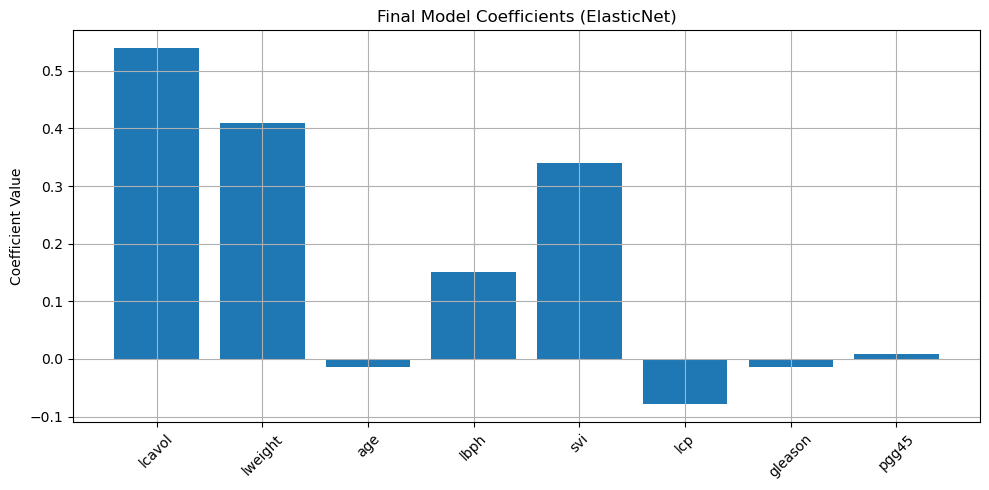

In [21]:
ft_names = X_train.columns.tolist()

# Get coefficients from trained model
coef = final_model.coef_

# Convert CuPy array to NumPy for plotting
coef_np = cp.asnumpy(coef)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(ft_names, coef_np)
plt.xticks(rotation=45)
plt.title("Final Model Coefficients (ElasticNet)")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()

## __Elastic Net Question 3__
#### __3.0 Run print(fetch_california_housing().DESCR) to review detailed information about the data.__

In [22]:
# 1. Load the dataset
housing = fetch_california_housing()
print(fetch_california_housing().DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

#### __3.1 Load the dataset. Make sure to load the features (X) and target (y) separately.__ 

In [23]:
X_pd, y_pd = housing.data, housing.target
feature_names = housing.feature_names

In [24]:
# Convert to cuDF
X = cudf.DataFrame(X_pd, columns=feature_names)
y = cudf.Series(y_pd)

#### __3.2 Compute a summary statistics (count, mean, standard deviation, min, 25%, 50%, 75% percentiles, max) for each variable including the target.__ 

In [25]:
# 2. Summary statistics (including target)
summary = X.copy()
summary['target'] = y
print("\nSummary Statistics:")
print(summary.describe())


Summary Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        

In [26]:
# 3. Correlation with the target
summary['target'] = y
correlations = summary.corr()['target'].drop('target')
correlations = correlations.to_pandas()

#### __3.3 Plot a bar chart showing the correlation between the target and each feature.__ 

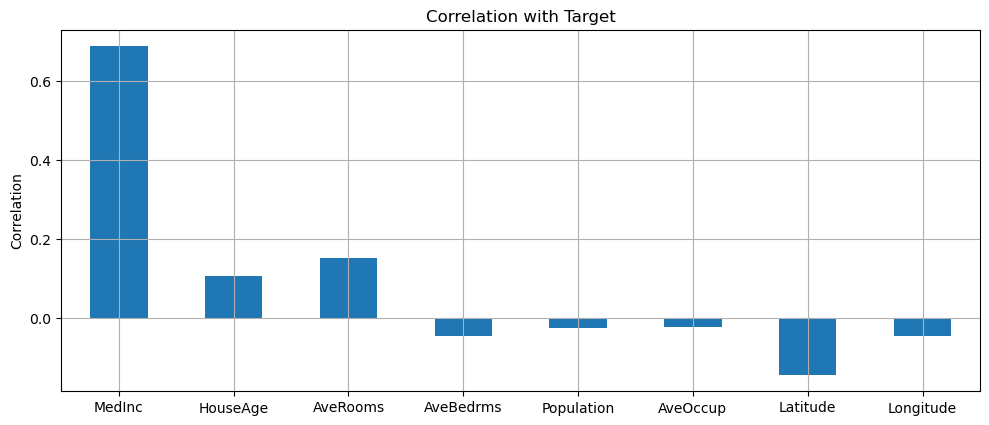

In [27]:
# Plot bar chart of correlation
plt.figure(figsize=(10, 5))
correlations.plot(kind='bar')
plt.title('Correlation with Target')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

#### __3.4 Normalize and split the data into training, validation, and testing datasets.__ 

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features using cuML's StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.columns = feature_names
X_test.columns = feature_names

In [29]:
original_filters = warnings.filters[:]
# Suppress all warnings
warnings.filterwarnings("ignore")

#### __3.5 Initiate a elasticnet in sklearn. Select a range of values of alpha and l1_ratio (hyperparameter space), set up the GridSearchCV with cv=3 and scoring='negative_mean_squared_error' and execute the model fit.__ 

In [30]:
# 5. Manual GridSearchCV with cuML ElasticNet
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []
for alpha in param_grid['alpha']:
    for l1 in param_grid['l1_ratio']:
        scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr = X_train.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_val_fold = X_train.iloc[val_idx]
            y_val_fold = y_train.iloc[val_idx]

            model = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=10000)
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val_fold)

            neg_mse = -1 * mean_squared_error(y_val_fold.to_cupy(), y_pred.to_cupy())
            scores.append(neg_mse)

        avg_nmse = cp.mean(cp.array(scores))
        results.append((alpha, l1, float(avg_nmse)))

In [31]:
warnings.filters = original_filters

#### __3.6 Report the cross-validation results.__ 

In [32]:
results_df = cudf.DataFrame(results, columns=['alpha', 'l1_ratio', 'mean_nmse'])
results_df = results_df.sort_values(by='mean_nmse', ascending=False)
print("\nCross-validation results:")
print(results_df)


Cross-validation results:
    alpha  l1_ratio  mean_nmse
0    0.01       0.1  -0.527187
1    0.01       0.5  -0.527767
2    0.01       0.9  -0.529148
3    0.10       0.1  -0.584980
4    0.10       0.5  -0.632972
5    0.10       0.9  -0.672952
6    1.00       0.1  -0.871672
7    1.00       0.5  -1.063304
8    1.00       0.9  -1.334614
9   10.00       0.1  -1.334614
10  10.00       0.5  -1.334614
11  10.00       0.9  -1.334614


#### __3.7 Which model was selected?__ 

In [33]:
# 7. Best model selection
best_params = results_df.iloc[0]
best_alpha = float(best_params['alpha'])
best_l1 = float(best_params['l1_ratio'])
print(f"\nSelected Model: alpha={best_alpha}, l1_ratio={best_l1}")


Selected Model: alpha=0.01, l1_ratio=0.1


#### __3.8 Evaluate the model on the test dataset. Report the root of the mean squared error.__ 

In [34]:
# 8. Final model training and test evaluation
final_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=10000)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

rmse = mean_squared_error(y_test.to_cupy(), y_pred_test.to_cupy(), squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.7290


#### __3.9 Plot a bar chart with the final parameter estimates.__ 

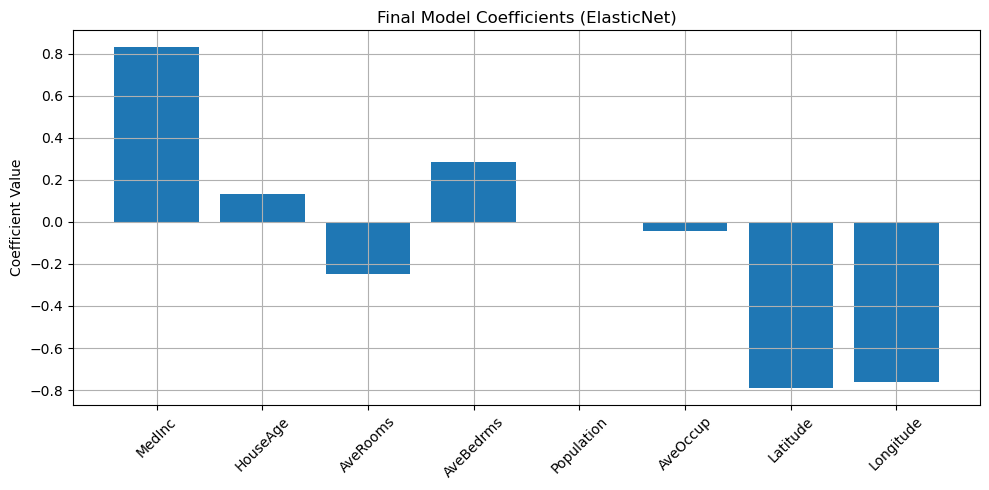

In [35]:
# 9. Plot final coefficients
coef = final_model.coef_
coef_np = cp.asnumpy(coef)

plt.figure(figsize=(10, 5))
plt.bar(feature_names, coef_np)
plt.xticks(rotation=45)
plt.title("Final Model Coefficients (ElasticNet)")
plt.ylabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()


## __Logistic Regression Question 4__
#### __4.0 Load the data and review information about the data.__

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [37]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
column_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names"

# Load the dataset (features and target)
columns = [
    "word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", "word_freq_our",
    "word_freq_over", "word_freq_remove", "word_freq_internet", "word_freq_order", "word_freq_mail",
    "word_freq_receive", "word_freq_will", "word_freq_people", "word_freq_report", "word_freq_addresses",
    "word_freq_free", "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit",
    "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp",
    "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs",
    "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85",
    "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
    "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re",
    "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(",
    "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_#", "capital_run_length_average",
    "capital_run_length_longest", "capital_run_length_total", "is_spam"
]
data = pd.read_csv(url, header=None, names=columns)

In [38]:
data.shape

(4601, 58)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4601 non-null   float64
 1   word_freq_address           4601 non-null   float64
 2   word_freq_all               4601 non-null   float64
 3   word_freq_3d                4601 non-null   float64
 4   word_freq_our               4601 non-null   float64
 5   word_freq_over              4601 non-null   float64
 6   word_freq_remove            4601 non-null   float64
 7   word_freq_internet          4601 non-null   float64
 8   word_freq_order             4601 non-null   float64
 9   word_freq_mail              4601 non-null   float64
 10  word_freq_receive           4601 non-null   float64
 11  word_freq_will              4601 non-null   float64
 12  word_freq_people            4601 non-null   float64
 13  word_freq_report            4601 

### __4.1 Load the dataset. Make sure to load the features (X) and target (y) separately.__

In [40]:
X=data.drop(columns=["is_spam"])
y=data["is_spam"]

### __4.2 Compute a summary statistics (count, mean, standard deviation, min,  25%, 50% , 75% percentiles, max) for each variable including the target.__

In [41]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.104553,0.305358,0.0,0.000,0.000,0.000,4.540
word_freq_address,4601.0,0.213015,1.290575,0.0,0.000,0.000,0.000,14.280
word_freq_all,4601.0,0.280656,0.504143,0.0,0.000,0.000,0.420,5.100
word_freq_3d,4601.0,0.065425,1.395151,0.0,0.000,0.000,0.000,42.810
word_freq_our,4601.0,0.312223,0.672513,0.0,0.000,0.000,0.380,10.000
word_freq_over,4601.0,0.095901,0.273824,0.0,0.000,0.000,0.000,5.880
word_freq_remove,4601.0,0.114208,0.391441,0.0,0.000,0.000,0.000,7.270
word_freq_internet,4601.0,0.105295,0.401071,0.0,0.000,0.000,0.000,11.110
word_freq_order,4601.0,0.090067,0.278616,0.0,0.000,0.000,0.000,5.260
word_freq_mail,4601.0,0.239413,0.644755,0.0,0.000,0.000,0.160,18.180


### __4.3 Plot a bar chart showing the correlation between the target and each feature__

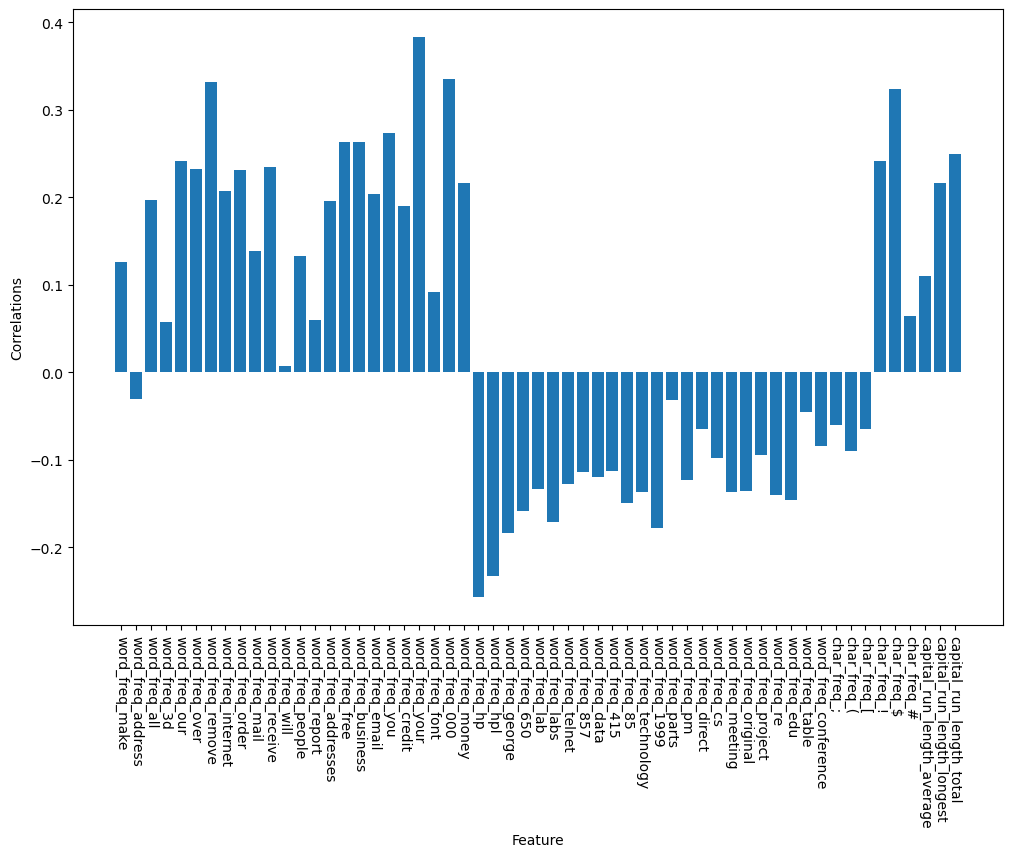

In [42]:
correlations=X.corrwith(y)
plt.figure(figsize=(12, 8))
plt.bar(X.columns, correlations)
plt.xlabel("Feature")
plt.ylabel("Correlations")
plt.xticks(rotation=270)
plt.show()

### __4.4 Normalize and split the data into training, validation, and testing datasets.__

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing datasets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

### __4.5 Initiate a LogisticRegression module with elasticnet penalty in sklearn. Select a range of values of C and l1_ratio (hyperparameter space), set up the GridSearchCV with cv=3 and scoring='accuracy' and execute the model fit.__

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# Initiate Logistic Regression with elasticnet penalty
log_reg = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)

# Define hyperparameter grid
param_grid = { 'C': [0.01, 0.1, 1, 10, 100],
               'l1_ratio': [0, 0.25, 0.5, 0.75, 1 ]}

# Set up GridSearchCV with accuracy as the scoring metric
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=10000, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='accuracy', verbose=1)

### __4.6 Report the cross-validation results__

In [45]:
results_df=pd.DataFrame(grid_search.cv_results_)
columns_to_display=["param_C","param_l1_ratio","mean_test_score","rank_test_score"]
results_df=results_df[columns_to_display]
results_df=results_df.sort_values(by="rank_test_score")
results_df

,param_C,param_l1_ratio,mean_test_score,rank_test_score
22,100.00,0.50,0.921121,1
24,100.00,1.00,0.920810,2
21,100.00,0.25,0.920810,2
20,100.00,0.00,0.920810,2
17,10.00,0.50,0.920810,2
16,10.00,0.25,0.920810,2
23,100.00,0.75,0.920810,2
15,10.00,0.00,0.920500,8
19,10.00,1.00,0.920499,9
18,10.00,0.75,0.920499,9


### __4.7 Which model was selected?__

In [46]:
best_model = grid_search.best_estimator_
print("Best Model Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Model Parameters: {'C': 100, 'l1_ratio': 0.5}
Best Cross-Validation Accuracy: 0.9211206968864453


### __4.8 Evaluate the model on the test dataset. Report the squared root of the accuracy.__

In [47]:
from sklearn.metrics import accuracy_score

y_test_pred = best_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)

sqrt_accuracy = np.sqrt(test_accuracy)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))


print(f"Test Accuracy: {test_accuracy:.4f}")
print("Root Mean Squared Error (RMSE) on Test Data:", rmse)
print(f"Square Root of Test Accuracy: {sqrt_accuracy:.4f}")

Test Accuracy: 0.9261
Root Mean Squared Error (RMSE) on Test Data: 0.27177108397591776
Square Root of Test Accuracy: 0.9624


### __4.9 Display the top 10 positive parameter estimates. Display the top 10 negative parameter estimates.__

Top 10 Positive Coefficients:
word_freq_3d                  1.736015
char_freq_$                   1.194089
char_freq_#                   1.121411
word_freq_free                0.927316
word_freq_000                 0.887478
capital_run_length_longest    0.884038
word_freq_remove              0.857588
word_freq_credit              0.711239
capital_run_length_total      0.695864
word_freq_technology          0.482685
dtype: float64

Top 10 Negative Coefficients:
word_freq_george       -8.530872
word_freq_hp           -3.279482
word_freq_cs           -3.076770
word_freq_project      -1.580752
word_freq_meeting      -1.333148
word_freq_lab          -1.279446
word_freq_edu          -1.209846
word_freq_conference   -1.125654
word_freq_85           -0.823397
word_freq_hpl          -0.774627
dtype: float64


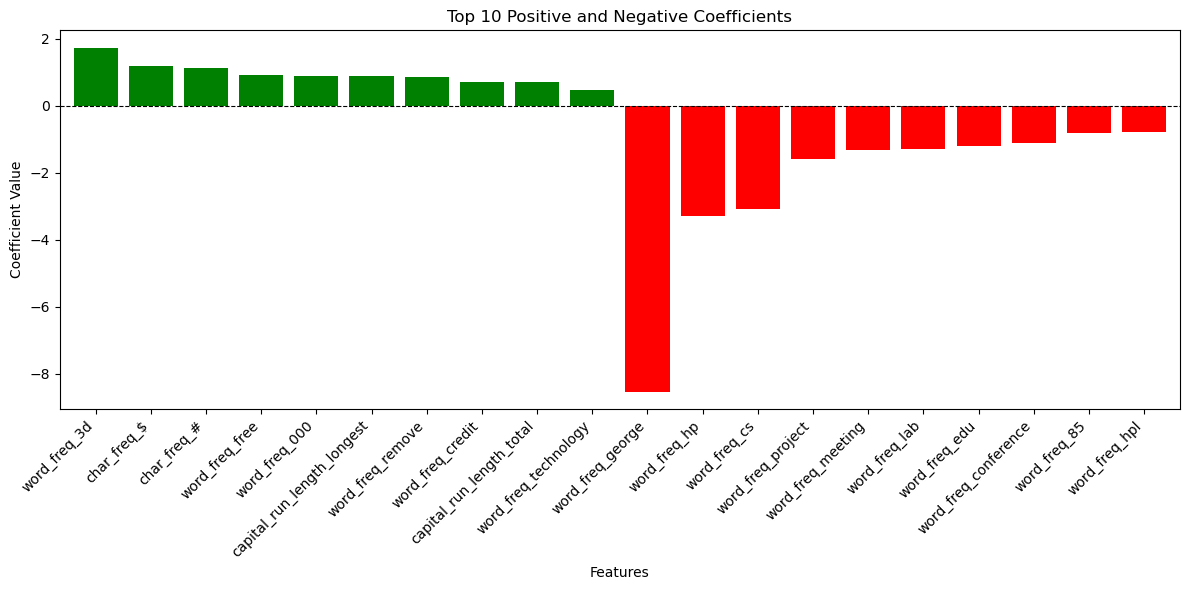

In [48]:
import matplotlib.pyplot as plt

coefficients = pd.Series(best_model.coef_.flatten(), index=X.columns)

# Get the top 10 positive and top 10 negative coefficients
top_10_positive = coefficients.nlargest(10)
top_10_negative = coefficients.nsmallest(10)

print("Top 10 Positive Coefficients:")
print(top_10_positive)

print("\nTop 10 Negative Coefficients:")
print(top_10_negative)

top_10_combined = pd.concat([top_10_positive, top_10_negative])

plt.figure(figsize=(12, 6))
top_10_combined.plot(kind='bar', color=['green' if x > 0 else 'red' for x in top_10_combined], width=0.8)
plt.title("Top 10 Positive and Negative Coefficients")
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.tight_layout()
plt.show()



## __Multinomial Regression Question 5__

*from* ``0001-03-02-02_multinomial-regression_homework-q1.html``

The ``mnist_784`` dataset can be used for classification tasks. The data and detail information can be found here: https://www.openml.org/search?type=data&sort=runs&id=554&status=active.

#### __5.0 Load the dataset. Make sure to load the features ($X$) and target ($y$) separately.__

In [49]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [50]:
X, y = mnist['data'], mnist['target']
y = y.astype(int)

In [51]:
X_cudf = cudf.DataFrame.from_records(X.to_numpy())
y_cudf = cudf.Series(y)

### __5.1 Normalize and split the data into training, validation, and testing datasets.__

In [52]:
X_train0, X_test0, y_train, y_test = cuml.model_selection.train_test_split(
    X_cudf, y_cudf, train_size=0.7, random_state=23
)

In [53]:
scaler = cuml.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train0)
X_test = scaler.transform(X_test0)

### __5.2 Initiate and configure ``LogisticRegression`` in ``sklearn`` for a multinomial regression. Select a range of values of ``C`` and ``l1_ratio`` (hyperparameter space), set up the ``GridSearchCV`` with ``cv`` and select a ``scoring`` to measure the model performance. Execute the model fit.__

In [54]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class RAPIDSLogRegWrapper(BaseEstimator, ClassifierMixin):
  def __init__(self, C=1.0, l1_ratio=0.5):
    self.penalty = 'elasticnet'
    self.C = C
    self.l1_ratio = l1_ratio

  def fit(self, X, y):
    self.model_ = cuml.LogisticRegression(
        penalty=self.penalty,
        C=self.C,
        l1_ratio=self.l1_ratio
    )
    self.model_.fit(X, y)
    return self

  def predict(self, X):
    return self.model_.predict(X).to_numpy()

  def predict_proba(self, X):
    return self.model_.predict_proba(X).to_numpy()

  def score(self, X, y):
    y_pred = self.predict(X)
    return accuracy_score(y.to_numpy(), y_pred)

In [55]:
original_filters = warnings.filters[:]
# Suppress all warnings
warnings.filterwarnings("ignore")

In [56]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 1, 100],
    'l1_ratio': [0.0, 0.5, 1.0],
}

logreg = RAPIDSLogRegWrapper()
logregCV = GridSearchCV(logreg, param_grid, cv=3)
model = logregCV.fit(X_train, y_train)

[2025-04-07 05:47:14.997] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-07 05:47:14.999] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-04-07 05:47:29.394] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-07 05:47:29.395] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-04-07 05:47:42.718] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-07 05:47:42.719] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[2025-04-07 05:47:57.304] [CUML] [warning] QWL-QN: max iterations reached
[2025-04-07 05:47:57.305] [CUML] [warning] M

In [57]:
warnings.filters = original_filters

### __5.3 Report the cross-validation results.__

In [58]:
model.cv_results_

{'mean_fit_time': array([ 2.68830307,  2.8758386 ,  3.9101603 ,  6.54974278, 13.70102286,
        14.15127023, 14.37027915, 13.42052205, 13.35500813]),
 'std_fit_time': array([0.10840699, 0.03666776, 0.17029293, 0.55691745, 0.4640014 ,
        0.57902055, 0.42705573, 0.32510547, 0.47958184]),
 'mean_score_time': array([0.05683454, 0.05550106, 0.05849044, 0.05878345, 0.05154252,
        0.06222876, 0.05746357, 0.05620074, 0.05368646]),
 'std_score_time': array([0.00085435, 0.00333242, 0.00412677, 0.00338694, 0.00099828,
        0.00319742, 0.00196803, 0.00758072, 0.00290214]),
 'param_C': masked_array(data=[0.01, 0.01, 0.01, 1.0, 1.0, 1.0, 100.0, 100.0, 100.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=1e+20),
 'param_l1_ratio': masked_array(data=[0.0, 0.5, 1.0, 0.0, 0.5, 1.0, 0.0, 0.5, 1.0],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill

### __5.4 Which model was selected?__

In [59]:
model.best_estimator_

RAPIDSLogRegWrapper(C=0.01, l1_ratio=0.0)

### __5.5 Evaluate the model on the test dataset. Report the ``accuracy score``.__

In [60]:
test_preds = model.best_estimator_.predict(X_test)
test_probs = model.best_estimator_.predict_proba(X_test)

In [61]:
print("Test Accuracy:", accuracy_score(y_test.to_numpy(), test_preds))

Test Accuracy: 0.9217142857142857


### __5.6 Display a small sample of the images from the testing dataset. Show the associated probability prediction vector for each.__

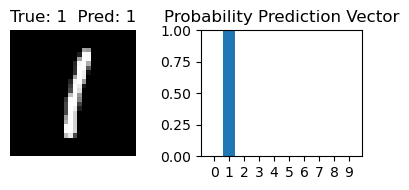

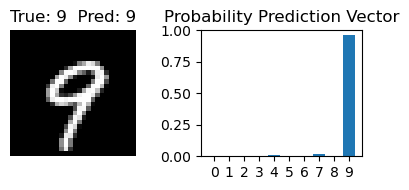

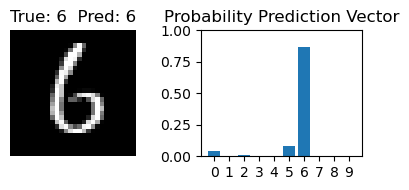

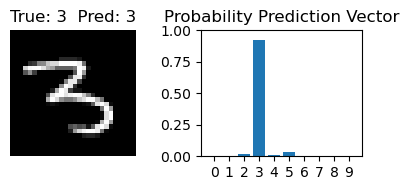

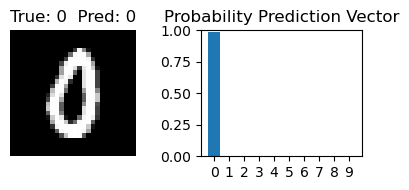

In [62]:
num_samples = 5
rand_i = np.random.choice(len(X_test0), size=num_samples, replace=False)
images = X_test0.iloc[rand_i].to_numpy()
labels = y_test.iloc[rand_i].to_numpy()

for i in np.arange(num_samples):
    plt.figure(figsize=(4, 2))

    plt.subplot(1, 2, 1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'True: {labels[i]}  Pred: {test_preds[rand_i[i]]}')

    plt.subplot(1, 2, 2)
    plt.bar(range(10), test_probs[rand_i[i]])
    plt.xticks(range(10))
    plt.ylim(0, 1)
    plt.title("Probability Prediction Vector")

    plt.tight_layout()
    plt.show()